In [1]:
import os
import sys
main_path = os.path.abspath(os.path.join(os.path.dirname("./resolution_search.ipynb"), '..'))
print(main_path)
sys.path.insert(0, main_path)
from src.preprocesing import get_mmbopf_plasticc_path, rearrange_splits, gen_dataset_from_h5
from src.mmmbopf.method import IBOPF
from src.mmmbopf.models import CompactIBOPF
from src.feature_selection.analysis_of_variance import manova_rank_fast
import numpy as np
from scipy import sparse
import pandas as pd
import seaborn as snb
import matplotlib.pyplot as plt
import json

data_path = get_mmbopf_plasticc_path()
print(data_path)
resolution_search_main_directory = os.path.join(data_path, "resolution_search")
print(resolution_search_main_directory)
import joblib
import avocado
from statsmodels.multivariate.manova import MANOVA
plt.style.use('seaborn')
%matplotlib inline

D:\tesis
../data/plasticc/IBOPF
../data/plasticc/IBOPF\resolution_search


In [2]:
filepath = "D:/tesis/data/plasticc/IBOPF/models/features_v3_zero_variance_model.pkl"
pipeline = joblib.load(filepath)

In [3]:
features = avocado.read_dataframe(
    "D:/tesis/data/plasticc/IBOPF/sparse_features/features_v3_LSA_plasticc_augment_v3.h5",
    "features",
)
print(features.shape)
features2 = pipeline.transform(features)
print(features2.shape)

(80856, 816)
(80856, 768)


In [4]:
sparse_features = sparse.csr_matrix(features.values)

In [5]:
metadata = avocado.load("plasticc_augment_v3", metadata_only=True)
labels = metadata.metadata["class"].to_numpy()

In [6]:
%%time
method = IBOPF()
method.config_from_json("D:/tesis/data/plasticc/IBOPF/optimal_config_lsa.json")
method.print_config()

CONFIG FOR GENERAL IBOPF:
>> ALPHA:  4
>> STATISTICAL QUANTITIES:  (TrMm-MmMn-MmMx-TrMn)
>> LEVELS OF RESOLUTION:  [[110.428, 1], [406.482, 1]]
Wall time: 997 µs


In [16]:
%%time
method.C = "LSA"
model_lsa = CompactIBOPF(method="LSA")
model_lsa.set_pipeline(method, 6, 768, None)
model_lsa.pipeline.named_steps["lsa"].sc = 816
model_lsa.fit(sparse_features)
lsa_features = model_lsa.transform(sparse_features)

In [7]:
%%time
method.C = "MANOVA"
model_manova = CompactIBOPF(method="MANOVA")
model_manova.set_pipeline(method, 6, 816//6, None)
model_manova.pipeline.named_steps["manova"].k = 816//6
model_manova.fit(sparse_features, y=labels)
manova_features = model_manova.transform(sparse_features)
manova_features = manova_features.toarray()

C:\ProgramData\Miniconda3\envs\py37\lib\site-packages\numba\core\ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'parameters' of function 'feature_grouping_fast'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\src\feature_selection\analysis_of_variance.py", line 10:
@jit(nopython=True)
def feature_grouping_fast(X, n_features, n_variables, parameters):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


8/136 features failed because of absence of dependent variables
Wall time: 6.69 s


In [8]:
def k_top_mask(scores, k, parameters, n_variables):
    mask = np.zeros(scores.shape, dtype=bool)
    mask[np.argsort(scores, kind="mergesort")[-k:]] = 1
    
    bop_sizes = []
    for param in parameters:
        (win, wl, q, alpha, q_symbol, tol, mean_bp, num_reduction, threshold) = param
        bop_size = (np.array(alpha).prod() + 1) ** wl
        bop_sizes.append(bop_size)
            
    mask_extended = np.zeros(mask.shape[0] * n_variables, dtype=bool)

    k = 0
    for bsize in bop_sizes:
        for i in range(bsize):
            mask_val = mask[k + i]
            for j in range(n_variables):
                mask_extended[k * n_variables + bsize * j + i] = mask_val
        k += bsize

    return mask_extended

def cum_explained_variance_manova(X, scores, parameters, n_variables, normalize=True):
    cum_exp_var = [0]
    var_full = np.var(X, axis=0).sum()
    for k in range(1, len(scores)):
        mask = k_top_mask(scores, k, parameters, n_variables)
        reduced = X[:, mask]
        cum_exp_var_k = np.var(reduced, axis=0).sum() / var_full
        cum_exp_var.append(cum_exp_var_k)
        
    if normalize:
        cum_exp_var = (cum_exp_var - np.min(cum_exp_var))/(np.max(cum_exp_var)-np.min(cum_exp_var))
        
    return cum_exp_var
    
    

In [9]:
scores = model_manova.pipeline.named_steps["manova"].scores_


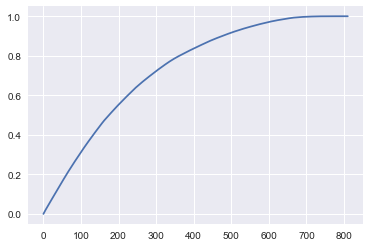

In [15]:
x0 = np.cumsum(np.sort(scores)[::-1])
x0 = (x0 - np.min(x0))/(np.max(x0) - np.min(x0))
plt.plot(np.arange(len(scores)) * 6, x0, label="MANOVA wilks lambda")

In [19]:
x1 = cum_explained_variance_manova(manova_features, scores, method.get_parameters(), 6)

In [17]:
def cum_explained_variance(full_fea, transformed_fea, normalize=True):
    explained_variances = np.var(transformed_fea, axis=0) / np.var(full_fea, axis=0).sum()
    cum_explained_variances = np.cumsum(explained_variances)
    if normalize:
        cum_explained_variances = (cum_explained_variances - np.min(cum_explained_variances)) / (np.max(cum_explained_variances) - np.min(cum_explained_variances))
    return cum_explained_variances

x2 = cum_explained_variance(manova_features, lsa_features)

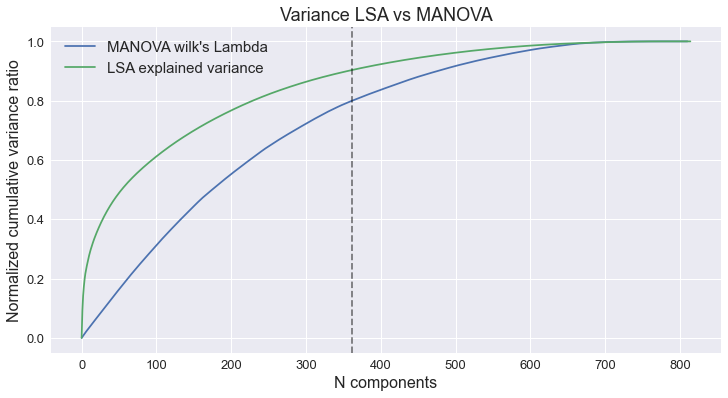

In [25]:
fig = plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(scores)) * 6, x0, label="MANOVA wilk's Lambda")
plt.plot(x2, label="LSA explained variance")
plt.axvline(361, color='k', linestyle="--", alpha=0.5)
# plt.plot(x3, label="LSA + DROP_ZERO_VAR")
plt.xlabel("N components", fontsize=16)
plt.ylabel("Normalized cumulative variance ratio", fontsize=16)
plt.title("Variance LSA vs MANOVA", fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.savefig("figs/explained_variance.png", dpi=300)